<a href="https://colab.research.google.com/github/michaelHalloran21/Stock_Prediction_with_Machine_Learning/blob/AD/Team_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from openbb_terminal.sdk import openbb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import vectorbt as vbt
import pyfolio as pf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [ ]:
# Fetch data using OpenBB
def fetch_data(tickers, start, end):
    combined = []
    for ticker in tickers:
        try:
            data = openbb.stocks.load(ticker, start_date=start, end_date=end)
            if not data.empty:
                data['Ticker'] = ticker
                combined.append(data)
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
    if combined:
        return pd.concat(combined).reset_index()
    return pd.DataFrame()

In [ ]:
# Fetch S&P 500 tickers
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_tickers = pd.read_html(url)[0]['Symbol'].tolist()

In [ ]:
# Define date range
start_date = "2015-01-01"
end_date = "2023-12-31"

In [ ]:
# Define tickers
stock_data = fetch_data(sp500_tickers[:10], start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data saved to 'stock_data/combined_stock_data.csv'


In [ ]:
# Feature Engineering
def add_features(df):
    df = df.sort_values(["Ticker", "date"])
    # SMA, EMA, MACD
    df["SMA_10"] = df.groupby("Ticker")["close"].transform(lambda x: x.rolling(10).mean())
    df["EMA_12"] = df.groupby("Ticker")["close"].transform(lambda x: x.ewm(span=12).mean())
    df["EMA_26"] = df.groupby("Ticker")["close"].transform(lambda x: x.ewm(span=26).mean())
    df["MACD"] = df["EMA_12"] - df["EMA_26"]
    # RSI
    def rsi(series, window=14):
        delta = series.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window).mean()
        avg_loss = loss.rolling(window).mean()
        rs = avg_gain / avg_loss
        return 100 - (100 / (1 + rs))
    df["RSI"] = df.groupby("Ticker")["close"].transform(rsi)
    return df.dropna()


In [ ]:
stock_data = add_features(stock_data)

In [ ]:
# Prepare data for Machine Learning with time-based split
stock_data = stock_data.sort_values("date")
split_date = "2020-01-01"
train_data = stock_data[stock_data["date"] < split_date].copy()
test_data = stock_data[stock_data["date"] >= split_date].copy()

In [ ]:
features = ["SMA_10", "EMA_12", "EMA_26", "MACD", "RSI"]
X_train = train_data[features]
y_train = train_data["close"].shift(-1) > train_data["close"]
y_train = y_train.astype(int)

In [ ]:
X_test = test_data[features]
y_test = test_data["close"].shift(-1) > test_data["close"]
y_test = y_test.astype(int)

In [ ]:
# Train Machine Learning Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

In [ ]:
features = ["SMA_10", "SMA_50", "MACD", "RSI"]
X_train = train_data[features]
y_train = train_data["Target"]

In [ ]:
# Evaluate Model
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test.dropna(), y_pred[:len(y_test.dropna())]))

In [ ]:
# Add predictions to the DataFrame
stock_data.loc[test_data.index, "Predicted_Signal"] = y_pred[:len(test_data)]

RandomForestClassifier(random_state=42)

In [ ]:
# Backtest with Predictions
def backtest_strategy(df):
    df = df.sort_values(["Ticker", "date"])
    # Use machine learning predictions as signals
    entries = df["Predicted_Signal"] == 1
    exits = df["Predicted_Signal"] == 0

    pf_data = vbt.Portfolio.from_signals(
        close=df["close"],
        entries=entries,
        exits=exits,
        size=np.inf,
        direction='longonly',
        cash_sharing=True
    )
    return pf_data

In [ ]:
# Run the updated backtest
portfolio = backtest_strategy(stock_data)

In [ ]:
# Performance Metrics
print("Portfolio Performance:")
print(portfolio.performance())

            Strategy_Return_Ticker  Market_Return  Cumulative Market Returns  \
Date                                                                           
2015-03-17                     0.0      -0.011984                   0.988087   
2015-03-18                     0.0       0.013547                   1.001564   
2015-03-19                     0.0      -0.004878                   0.996691   
2015-03-20                     0.0       0.004998                   1.001685   
2015-03-23                     0.0      -0.002165                   0.999519   

            Cumulative Strategy Returns  
Date                                     
2015-03-17                          1.0  
2015-03-18                          1.0  
2015-03-19                          1.0  
2015-03-20                          1.0  
2015-03-23                          1.0  


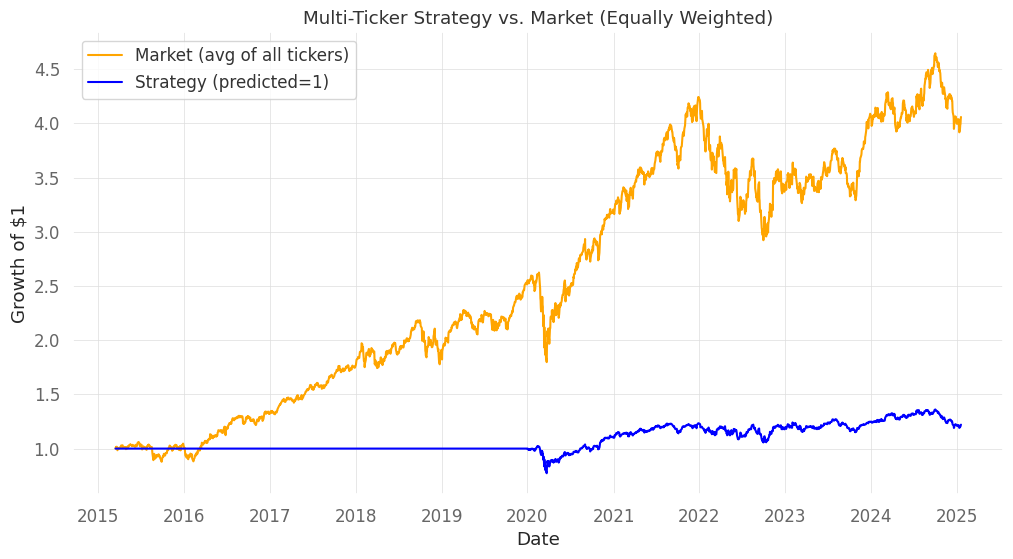

In [ ]:
# Generate Tearsheets using Pyfolio
returns = portfolio.daily_returns()
pf.create_full_tear_sheet(returns)

[Performance Metrics]



                           Strategy
-------------------------  ----------
Start Period               2015-03-17
End Period                 2025-01-17
Risk-Free Rate             0.0%
Time in Market             52.0%

Cumulative Return          15.05%
CAGR﹪                     0.99%

Sharpe                     0.19
Prob. Sharpe Ratio         71.82%
Smart Sharpe               0.15
Sortino                    0.26
Smart Sortino              0.21
Sortino/√2                 0.18
Smart Sortino/√2           0.15
Omega                      1.05

Max Drawdown               -25.76%
Longest DD Days            567
Volatility (ann.)          10.95%
Calmar                     0.04
Skew                       -0.91
Kurtosis                   37.57

Expected Daily %           0.01%
Expected Monthly %         0.12%
Expected Yearly %          1.28%
Kelly Criterion            2.63%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.13%
Expected Shortfall (cVaR)  -1.13%

Max Consecutive Wins      

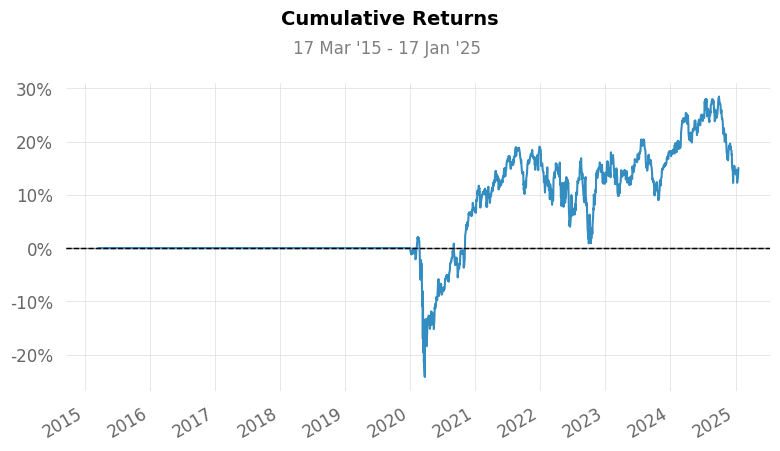

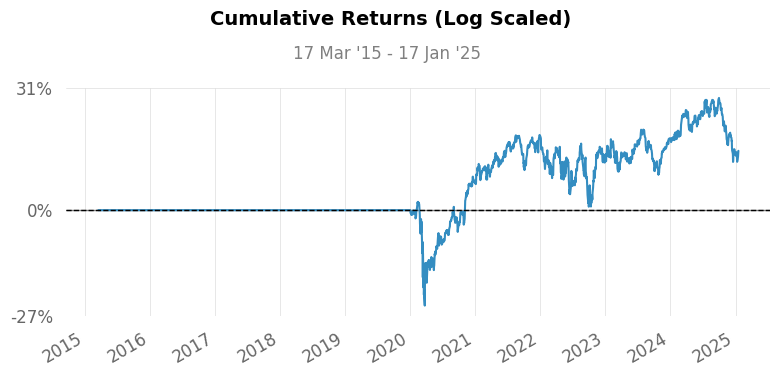

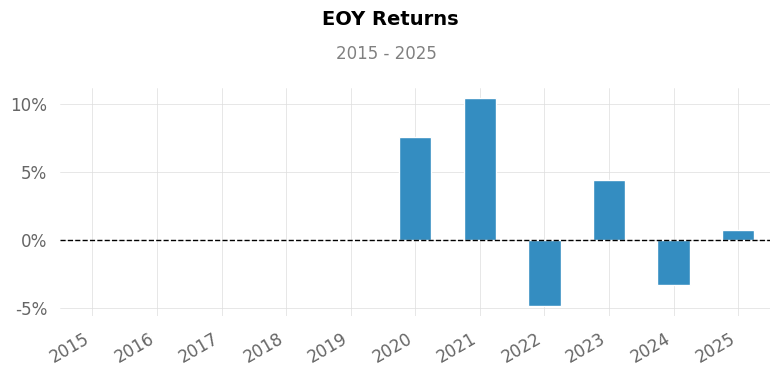

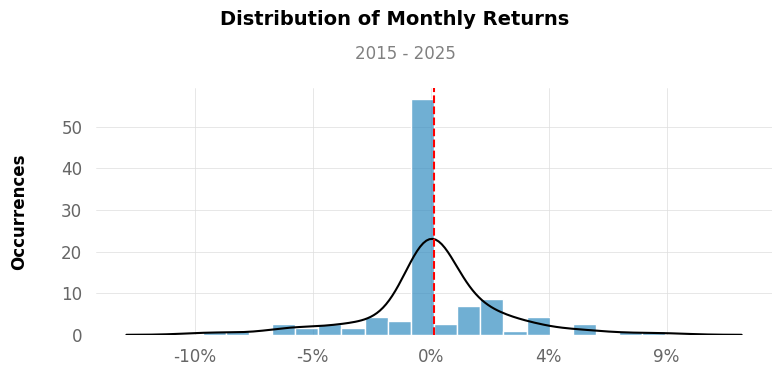

/usr/local/lib/python3.11/dist-packages/quantstats/_plotting/core.py:294: FutureWarning: Passing additional kwargs to DatetimeIndexResampler.sum has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  returns = returns.last() if compound is True else returns.sum(axis=0)


UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [ ]:
# Plot Cumulative Returns
portfolio.plot().show()